<a href="https://www.berlin.de/en/"><img src = "https://www.deutschland.de/sites/default/files/styles/crop_page/public/media/image/berlin-ranking-most-expensive-city-Global-Residential-Cities-Index.jpg?itok=jMfalIkn" width = 700> </a>

<h1 align=center><font size = 6>Analysis of land prices and venues in Berlin</font></h1>

## 1. Background and problem description
---
Berlin, the capital of Germany with a total population of 3.6 Million and an area of around 890 km2 [1], has recently grown more and more as a popular city in Central Europe accompanied by "skyrocketing" property prices. A study by the property consultancy Knight Frank, mentioned in [2], attributed the increase in property prices to the population growth, the stable economy, relatively low unemployment rates and interests from investors.

Up to the year 2030 the population in Berlin will approximately grow by 4.7% or 177,000 inhabitants. The average age will rise only relatively gently because of the continuing immigration of young people from 42.7 years in 2018 to 42,9 years in 2030. The positive development of the natural changes of population as the ratio between birth-rate and death-rate due to the ongoing increase in birth-rates will remain stable because it is assumed that immigration of young people will continue. Up to the year 2025, it is assumed, that the birth-rate will exceed the death-rate depending on immigration dynamics [3].

As a consequence of the changes, the social and economic dynamics in the city can be expected to rise. The popularity of the city probably will also lead to a growth in tourism. For people with their businesses positioned in the tourism and cultural sector (city tours, trips, museums, restaurants etc.), the state and development of the city structure might be important. This includes the distribution of venues and their popularity in space and time. This knowledige is key to find popular neighbourhoods in order to place specific offers.

However, some (potential) negative effects for the inhabitants of the city include, e. g. increasing housing prices, increasing prices in food places and bars or a higher number of tourists potentially leading to discomfort for some people. Thus, for policy-makers an analysis of venue data might be interesting to understand the city and the population better.

Therefore, the following questions will be addressed in this project:
1. What are characteristic venues in certain places in the city of Berlin?
2. How are the characteristic venues related to housing or land prices?

## 2. Data requirements and data description
---
In order to address the problems mentioned above, population, economic and venue data will be collected and analysed. This includes:

- borough geometry data (GeoJSON) [4],
- geographic positions of local centers [5],
- further information on boroughs i. e. population density [6] and land prices [7] and
- venue data of defined local centers [8].

The regional authority for statistics does not offer property prices by boroughs. Therefore, land prices will be used as a proxy for the popularity of a borough. In total, there are 12 boroughs in Berlin. In order to assess the venues in more detail, local centers will be defined and will be based on the zip codes. In total, Berlin has 190 zip codes distributed within the city area.

## 3. Methodology
---
### 3.1 Data collection, data wrangling and data cleaning
The main Python modules, that will be used for working with the data include:

- Request,
- BeautifulSoup,
- Pandas,
- Numpy,
- Geocoder and
- the Foursquare API.

They will be used for collecting and cleaning the data, reorganizing and transforming data including One-Hot-Encoding.

In [2]:
#The necessary modules will be loaded
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

import geocoder
import folium

### 3.2 Exploratory data analysis on boroughs and statistical data of Berlin
Berlin consists of twelve boroughs, that will be represented spatially with a GeoJSON file from and for which statistical on population density (2019) [6] and land prices in 2018 [7] were investigated. With the help of the Request and BeautifulSoup packages data could be scraped from the websites and transformed to Pandas-Dataframes as shown below.

In [3]:
#supply local GeoJSON file path
berlin_geojson='/Users/Alex/Downloads/Berlin-Geodaten-master/berlin_bezirke.geojson'

#scrape land price statistics 2018 from website and transform to BS-object
url = 'https://www.statistik-berlin-brandenburg.de/regionalstatistiken/r-gesamt_neu.asp?Ptyp=410&Sageb=61005&creg=BBB&anzwer=6'
website_content = requests.get(url).text
soup = BeautifulSoup(website_content,'lxml')

#extract land price table from html
table = soup.find('table',{'class':'table-regional'})
df1 = pd.read_html(str(table), decimal=',', thousands=' ')[0]

#cut land price table and drop unnecessary data
df1 = df1.iloc[1:13,[0,3]] #drop rows

#column names are broken, give them a proper name
cols = ['Borough name','Price in EUR per m2']
df1.columns = cols

#correct borough names and take out numbering e. g. 'XX ' by string operation
df1['Borough name'] = df1['Borough name'].str[3:]

#special correction for Tempelhof-Schöneberg, Neukölln and Treptow-Köpenick
df1['Borough name'][6:9] = ['Tempelhof-Schöneberg','Neukölln', 'Treptow-Köpenick']

df1

,Borough name,Price in EUR per m2
1,Mitte,2754.92
2,Friedrichshain-Kreuzberg,4482.36
3,Pankow,1199.56
4,Charlottenburg-Wilmersdorf,2724.02
5,Spandau,682.56
6,Steglitz-Zehlendorf,861.17
7,Tempelhof-Schöneberg,1228.79
8,Neukölln,494.23
9,Treptow-Köpenick,207.98
10,Marzahn-Hellersdorf,436.48


In [4]:
#scrape population density 2019 statistics from website and transform to BS-object
url = 'https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins'
website_content = requests.get(url).text
soup = BeautifulSoup(website_content,'lxml')

#extract land price table from html
table = soup.find('table',{'class':'wikitable sortable zebra'})
df2 = pd.read_html(str(table), decimal=',', thousands='.')[0]

#cut land table and drop unnecessary data
df2 = df2.iloc[:,[1,5]] #drop rows

#change columns' names
cols = ['Borough name','Population density 1000 by km2']
df2.columns = cols

#rescale values
df2['Population density 1000 by km2']=df2['Population density 1000 by km2']/1000.

#merge df2 with df1
df_boroughs = df1.merge(df2, on='Borough name')

#convert string objects to float
df_boroughs.iloc[:,1:] = df_boroughs.iloc[:,1:].astype(float)

df_boroughs

,Borough name,Price in EUR per m2,Population density 1000 by km2
0,Mitte,2754.92,9.733
1,Friedrichshain-Kreuzberg,4482.36,14.373
2,Pankow,1199.56,3.958
3,Charlottenburg-Wilmersdorf,2724.02,5.289
4,Spandau,682.56,2.655
5,Steglitz-Zehlendorf,861.17,3.012
6,Tempelhof-Schöneberg,1228.79,6.624
7,Neukölln,494.23,7.338
8,Treptow-Köpenick,207.98,1.610
9,Marzahn-Hellersdorf,436.48,4.350


Both, land prices and population density show wide ranges. Borough-based land prices from the year 2018 are between 208 (Treptow-Köpenick) and 4,482 (Friedrichshain-Kreuzberg) Euro per square kilometer. Both boroughs also hold the lowest and highest population densities of 1,610 and 14,370 inhabitants per square kilometer, respectively. The relationship between both parameters is shown below.

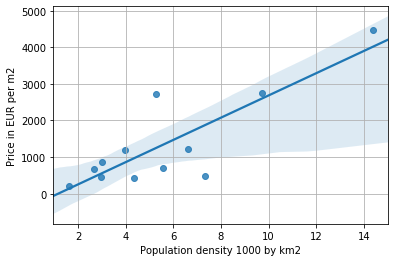

In [5]:
ax=sns.regplot(data=df_boroughs, x='Population density 1000 by km2', y='Price in EUR per m2')
ax.grid()
ax

The data suggests a linear relationship between population density of the boroughs and the land prices. The relationshop was expected, but still is an interesting fact. The more people live in a neighbourhood, the higher the land prices will be. One can expect, that this will also affect the category of venues in a local center or neighbourhood.

### 3.3 Coordinates of Berlin local centers and Foursquare venue data
The definition of the local centers will be based on the zip codes. First, they will be extracted from the source and cleaned. Then, the the Foursquare API will be used to explore all local centers or neighbourhoods.

In [6]:
local_centers = pd.read_csv('http://www.fa-technik.adfc.de/code/opengeodb/PLZ.tab', sep='\t')

#Select Berlin neighbourhoods from Germany
local_centers = local_centers[local_centers['Ort']=='Berlin']

#select only zip code and coordinates
local_centers = local_centers[['plz','lat', 'lon',]]

#make zip code the name
local_centers = local_centers.rename(columns={'plz': 'name'})

local_centers

,name,lat,lon
686,10115,52.533707,13.387224
687,10117,52.518746,13.390193
688,10119,52.532666,13.407149
689,10178,52.523474,13.412203
690,10179,52.514591,13.419699
...,...,...,...
873,14169,52.446430,13.265875
874,14193,52.476342,13.232888
875,14195,52.459317,13.286944
876,14197,52.475009,13.314679


In [153]:
#Credentials (taken out afterwards)
CLIENT_ID = 'ENQ4J3NG5IJ20QDPTPS0D30YBYHY22Z3WPOJS5TNL44S5CTS' # your Foursquare ID
CLIENT_SECRET = '2YIURR3PJKEBGZ5HMCT3XVMOMKBIEBSJ4MEIUF1W2SZYA5OW' # your Foursquare Secret
VERSION = '20180604'

def getNearbyVenues(names, latitudes, longitudes, radius=2500, limit=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [154]:
berlin_venues = getNearbyVenues(names=local_centers.name,latitudes=local_centers.lat,longitudes=local_centers.lon)

10115
10117
10119
10178
10179
10243
10245
10247
10249
10315
10317
10318
10319
10365
10367
10369
10405
10407
10409
10435
10437
10439
10551
10553
10555
10557
10559
10585
10587
10589
10623
10625
10627
10629
10707
10709
10711
10713
10715
10717
10719
10777
10779
10781
10783
10785
10787
10789
10823
10825
10827
10829
10961
10963
10965
10967
10969
10997
10999
12043
12045
12047
12049
12051
12053
12055
12057
12059
12099
12101
12103
12105
12107
12109
12157
12159
12161
12163
12165
12167
12169
12203
12205
12207
12209
12247
12249
12277
12279
12305
12307
12309
12347
12349
12351
12353
12355
12357
12359
12435
12437
12439
12459
12487
12489
12524
12526
12527
12555
12557
12559
12587
12589
12619
12621
12623
12627
12629
12679
12681
12683
12685
12687
12689
13051
13053
13055
13057
13059
13086
13088
13089
13125
13127
13129
13156
13158
13159
13187
13189
13347
13349
13351
13353
13355
13357
13359
13403
13405
13407
13409
13435
13437
13439
13465
13467
13469
13503
13505
13507
13509
13581
13583
13585
13587
13589
1359

The primary category will be assigned to the venue categories.

In [155]:
#get the full list of venue categories
foursquare_categories=requests.get('https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)).json()

#create a dictionary containing the subcategories as key and the primary category as value
foursquare_cats_dict={}

for primacat in foursquare_categories['response']['categories']:
    
    for subcat1 in primacat['categories']:
        foursquare_cats_dict[subcat1['name']]=subcat1['name']
        
        for subcat2 in subcat1['categories']:
            foursquare_cats_dict[subcat2['name']]=subcat1['name']
            
            for subcat3 in subcat2['categories']:
                foursquare_cats_dict[subcat3['name']]=subcat1['name']
                
                for subcat4 in subcat3['categories']:
                    foursquare_cats_dict[subcat4['name']]=subcat1['name']
        
foursquare_cats_dict

{'Amphitheater': 'Amphitheater',
 'Aquarium': 'Aquarium',
 'Arcade': 'Arcade',
 'Art Gallery': 'Art Gallery',
 'Bowling Alley': 'Bowling Alley',
 'Casino': 'Casino',
 'Circus': 'Circus',
 'Comedy Club': 'Comedy Club',
 'Concert Hall': 'Concert Hall',
 'Country Dance Club': 'Country Dance Club',
 'Disc Golf': 'Disc Golf',
 'Exhibit': 'Exhibit',
 'General Entertainment': 'General Entertainment',
 'Go Kart Track': 'Go Kart Track',
 'Historic Site': 'Historic Site',
 'Karaoke Box': 'Karaoke Box',
 'Laser Tag': 'Laser Tag',
 'Memorial Site': 'Memorial Site',
 'Mini Golf': 'Mini Golf',
 'Movie Theater': 'Movie Theater',
 'Drive-in Theater': 'Movie Theater',
 'Indie Movie Theater': 'Movie Theater',
 'Multiplex': 'Movie Theater',
 'Museum': 'Museum',
 'Art Museum': 'Museum',
 'Erotic Museum': 'Museum',
 'History Museum': 'Museum',
 'Planetarium': 'Museum',
 'Science Museum': 'Museum',
 'Music Venue': 'Music Venue',
 'Jazz Club': 'Music Venue',
 'Piano Bar': 'Music Venue',
 'Rock Club': 'Music 

In [156]:
berlin_venues['Primary Category']=berlin_venues['Venue Category'].map(foursquare_cats_dict)
print(berlin_venues.shape)
berlin_venues.head()

(8757, 8)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Primary Category
0,10115,52.533707,13.387224,Dokumentationszentrum | Documentation Center (...,52.535386,13.389668,History Museum,Museum
1,10115,52.533707,13.387224,Gedenkstätte Berliner Mauer,52.534896,13.390140,Historic Site,Historic Site
2,10115,52.533707,13.387224,Oslo Kaffebar,52.531029,13.386889,Coffee Shop,Coffee Shop
3,10115,52.533707,13.387224,Hotel i31,52.531107,13.384270,Hotel,Hotel
4,10115,52.533707,13.387224,19grams,52.533037,13.380054,Coffee Shop,Coffee Shop


The categories of the retrieved data will be checked.

In [157]:
print('There are {} unique primary categories.'.format(len(berlin_venues['Primary Category'].unique())))
print('')
print('There are {} unique venue subcategories.'.format(len(berlin_venues['Venue Category'].unique())))

There are 232 unique primary categories.

There are 346 unique venue subcategories.


Use one hot encoding to parametrize the venues with binary values and prepare the neighbourhoods for clustering.

In [158]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Primary Category']], prefix="", prefix_sep="")

# add zip code column back to dataframe
berlin_onehot['Neighbourhood'] = berlin_venues['Neighbourhood'] 

# move zip code column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

print(berlin_onehot.shape)
berlin_onehot.head()

(8757, 233)


,Neighbourhood,ATM,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Water Park,Waterfall,Waterfront,Windmill,Winery,Zoo
0,10115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10115,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The data will be grouped by neighbourhoods and the frequency of occurence calculated.

In [159]:
berlin_grouped = berlin_onehot.groupby('Neighbourhood').mean().reset_index()
berlin_grouped

,Neighbourhood,ATM,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Water Park,Waterfall,Waterfront,Windmill,Winery,Zoo
0,10115,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10117,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10119,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10178,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10179,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,14169,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,14193,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,14195,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,14197,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
berlin_grouped.shape

(190, 233)

### 3.4 Data visualization
Data visualization is important for understanding (spatial) relationships between data results and communicating these results in order to reach clear conclusions of the analyses. Matplotlib, Seaborn and Folium will be used as the primary visualization tools for

1) understanding the data and

2) linking model results to other spatial features.

e. g. by generating bar plots of cluster categories or by creating overview maps of the spatial distribution of the clusters and choropleth maps of land prices.

A first overview map of the distribution of local centers and the population density will be given.

In [161]:
berlin = geocoder.osm('Berlin, DE')
berlin.latlng

# create a plain map of Berlin
map_berlin = folium.Map(location=berlin.latlng, zoom_start=10, tiles='cartodbpositron')

#define thresholds
threshold_scale = [1,2,3,5,7.5,10,15]

# generate choropleth map using the land prices from 2018 of each borough
map_berlin.choropleth(
    geo_data=berlin_geojson,
    data=df_boroughs,
    columns=['Borough name', 'Population density 1000 by km2'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGnBu', 
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Population Density [1000 inhabitants/km2]')

for lat, lon, name in zip(local_centers.lat, local_centers.lon, local_centers.name):
    folium.CircleMarker(
        [lat, lon],
        radius=4, # define how big you want the circle markers to be
        color='k',
        fill=True,
        popup=name,
        fill_color='k',
        fill_opacity=0.6
    ).add_to(map_berlin)
    
map_berlin

### Clustering: K-Means
For further data analysis and modelling, K-Means, a non-supervised machine learning algorithm, will be used for clustering the venue data. For this, the readily available algorithm of the Scikit-Learn package will be applied. Euclidian distance will be used as a metric for the distance between individual venue data points and the centroids defining the clusters. An important unknown will be the number of clusters, that has to be defined beforehand. As the total error (distances of data points to centroids) will always decrease with an increasing number of clusters, the "Elbow method" will be used in order to find the optimal k. The "elbow point" is defined by a sudden softer decrease of the total error with increasing numbers of clusters.

#### Find the optimal k with "Elbow method"

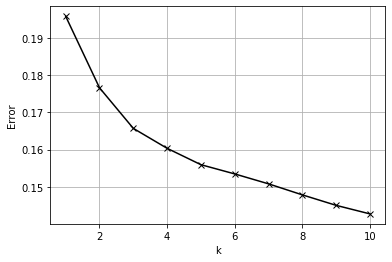

In [162]:
#drop neighbourhood columm
berlin_grouped_clustering = berlin_grouped.drop('Neighbourhood', 1)

# k means determine k
def kmeans_elbow(X):
    
    from scipy.spatial.distance import cdist
    import matplotlib.pyplot as plt
    
    errors = []
    K = range(1,11)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        errors.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    # Plot the elbow
    plt.plot(K, errors, 'kx-')
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.grid()
    plt.show()
    
kmeans_elbow(berlin_grouped_clustering)

There is no evident optimum for the number of clusters. One elbow point can be identified at k=2, but two clusters will not be sufficient to show different venue categories. However, k=5 will be chosen to be a reasonable number of clusters to perform the analysis.

#### Run K-Means with chosen k

In [163]:
no_clusters = 5 #define number of clusters k

#run algorithm
kmeans = KMeans(n_clusters=no_clusters).fit(berlin_grouped_clustering)

kmeans.labels_

array([4, 4, 0, 4, 4, 4, 0, 0, 4, 1, 0, 1, 1, 1, 4, 4, 0, 4, 3, 0, 0, 0,
       0, 4, 0, 4, 0, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 1, 2,
       2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1,
       2, 2, 2, 3, 1, 2, 0, 0, 0, 0, 3, 3, 0, 4, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 3, 1, 3, 3, 1,
       1, 3, 3, 2, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3], dtype=int32)

Update the dataframe with cluster labels:

In [164]:
#add clustering labels
berlin_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

local_centers_merged = local_centers

#merge berlin_grouped with berlin_data to add latitude/longitude for each neighborhood
local_centers_merged = local_centers_merged.join(berlin_grouped.set_index('Neighbourhood'), on='name')

#drop na clusters
local_centers_merged.dropna(inplace=True)

#restore int type in cluster labels
local_centers_merged = local_centers_merged.astype({"Cluster Labels": int})

local_centers_merged

,name,lat,lon,Cluster Labels,ATM,Adult Boutique,African Restaurant,Airport,American Restaurant,Amphitheater,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Water Park,Waterfall,Waterfront,Windmill,Winery,Zoo
686,10115,52.533707,13.387224,4,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
687,10117,52.518746,13.390193,4,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688,10119,52.532666,13.407149,0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,10178,52.523474,13.412203,4,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,10179,52.514591,13.419699,4,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,14169,52.446430,13.265875,3,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
874,14193,52.476342,13.232888,1,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
875,14195,52.459317,13.286944,3,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
876,14197,52.475009,13.314679,3,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Results
---
sdasd identify clusters.

Text(0, 0.5, 'Frequency')

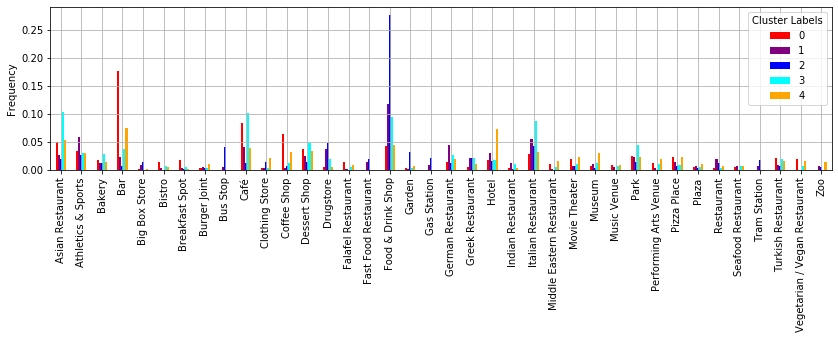

In [187]:
berlin_venue_cats_stats=local_centers_merged[local_centers_merged.columns[3:]].groupby('Cluster Labels').mean().transpose()

threshold=0.025

berlin_venue_cats_stats['Total']=berlin_venue_cats_stats.sum(axis=1)

berlin_venue_cats_stats=berlin_venue_cats_stats.loc[berlin_venue_cats_stats['Total']>threshold]

ax=berlin_venue_cats_stats[berlin_venue_cats_stats.columns[:-1]].plot(kind='bar', colors=['r','purple','b','cyan','orange'], grid=True, figsize=(14,3))
ax.set_ylabel('Frequency')


The final results will be visualized with maps and plots. Firstly, choropleth maps of the population density (2019) and land prices (2018) will be shown together with the modelling results from clustering.

In [180]:
# create a plain map of Berlin
map_clusters = folium.Map(location=berlin.latlng, zoom_start=10, tiles='cartodbpositron')

#define thresholds
threshold_scale = [1,2,3,5,7.5,10,15]

# generate choropleth map using the land prices from 2018 of each borough
map_clusters.choropleth(
    geo_data=berlin_geojson,
    data=df_boroughs,
    columns=['Borough name', 'Population density 1000 by km2'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGnBu', 
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Population Density [1000 inhabitants/km2]')

# set color scheme for the clusters
x = np.arange(no_clusters)
ys = [i + x + (i*x)**2 for i in range(no_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(local_centers_merged.lat, local_centers_merged.lon, local_centers_merged.name, local_centers_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [181]:
# create a plain map of Berlin
map_clusters = folium.Map(location=berlin.latlng, zoom_start=10, tiles='cartodbpositron')

#define thresholds for choropleth map
threshold_scale = [200,500,800,1200,2000,3000,4500]

# generate choropleth map using the land prices from 2018 of each borough
map_clusters.choropleth(
    geo_data=berlin_geojson,
    data=df_boroughs,
    columns=['Borough name', 'Price in EUR per m2'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Land prices 2018 [EUR/m2]')

# set color scheme for the clusters
x = np.arange(no_clusters)
ys = [i + x + (i*x)**2 for i in range(no_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(local_centers_merged.lat, local_centers_merged.lon, local_centers_merged.name, local_centers_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Discussion
---
The results will be discussed based on the research questions in Chapter 1:
What are characteristic venues in certain boroughs in the city of Berlin?
How are the characteristic venues related to housing or land prices?
The central part of the city is dominated by cluster categories 0 (red), 3 (green-cyan) and 4 (orange). These clusters are clearly dominated by venues like bars, cafés, restaurants and hotels. Still, there are slight differences, e. g. higher numbers of hotels in one than another cluster or cluster 4 being characterized by the Berlin Zoo. These clusters are linked to higher population densities (5,000 to 15,000 inhabitants per square kilometer) and also higher land prices (2,000 to 4,500 EUR per square meter).

Cluster 2 (blue) shows a low density of cafés and peripheric characteristics, such as bus stops and gardens. Also the population densities and land prices are moderate with 3,000 to 8,000 inhabitants per square kilometer and land prices up to around 2,000 EUR per square meter. This cluster category is dominant in the Eastern part of Berlin, especially in the Northeast. The tram infrastructure is quite strong in those boroughs because of historical reasons. In the German Democratic Republic this type of infrastructure was more popular than the construction of subway/underground tunnels.

Cluster 1 (purple) is spread in the outskirts and is mostly linked to lower population densities and land prices, i. e. 1,000 to 3,000 inhabitants per square kilometer and around 200 to 1,200 EUR per square meter, respectively. Here, the need of touristic infrastructures is very little compared to the boroughs in the city center, which is reflected in the characteristics of the cluster categories.

## 6. Conclusions
---
Based on the findings, it can be concluded, that highest land prices (up to 4,500 EUR per square meter) and population densities (up to 15,000 inhabitants per square kilometer) in the boroughs located in the city center of Berlin are linked to venue categories like bars, cafés and hotels reflecting the touristic infrastructure. The population densities and land prices are up to 20 times lower in the outskirts offering good opportunities for people to live cheaply or for business people to open bars and restaurants.

Based on the results, the following recommendations can be made for policy-makers:
Make outskirts more attractive for people, e. g. intensify and modernize infrastructure.

Facilitate the settlement of companies or other economic structures to vivify the boroughs outside the city center.

Furthermore, the outskirts offer good opportunities to open bars, cafés or restaurants as land prices are still low. For instance, the frequencies of occurrence of coffee places or turkish restaurants are relatively low, so these types of venues might be successful in those neighbourhoods. However, also the population density is low, so the potential of customers is restricted. For every case of potential new venues to be opened, it is recommendable to carry out a more detailed analysis as this project only offers an overview for the whole city.

It could further be shown, that open statistical data from local authorities combined with venue data from the Foursquare API can be powerful tools to analyse local centers or neighbourhoods of cities.

## 7. Sources
---
[1] Wikipedia article: https://de.wikipedia.org/wiki/Berlin (accessed: 17 March 2020)

[2] deutschland.de (2018): https://www.deutschland.de/en/topic/life/berlin-property-price-growth-fastest-in-world (accessed: 17 March 2020)

[3] SenStadtWohn (2020): https://www.stadtentwicklung.berlin.de/planen/bevoelkerungsprognose/de/ergebnisse/index.shtml (accessed: 17 March 2020)

[4] Berlin GeoJSON file: https://github.com/funkeinteraktiv/Berlin-Geodaten (accessed: 17 March 2020)

[5] ADFC Fachabteilung Technik (zip codes): 'http://www.fa-technik.adfc.de/code/opengeodb/PLZ.tab' (accessed: 17 March 2020)

[5] Wikipedia data table: https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins  (accessed: 17 March 2020)

[6] Amt für Statistik Berlin und Brandenburg: https://www.statistik-berlin-brandenburg.de/regionalstatistiken/r-gesamt_neu.asp?Ptyp=410&Sageb=61005&creg=BBB&anzwer=6 (accessed: 17 March 2020)

[7] Foursquare API venue data: https://de.foursquare.com (accessed: 17 March 2020)